In [1]:
import sys 
sys.path.append("../PyTIE/")
sys.path.append("../SimLTEM/")
from TIE_helper import show_im, show_2D
from sim_helper import *
from TIE_reconstruct import TIE, SITIE
from comp_phase import mansPhi, linsupPhi
import numpy as np

%matplotlib widget

In [2]:
file = "./example_mumax.ovf"
B0 = 1e4 # gauss
sample_V0 = 20 # V
sample_xip0 = 50 # nm
mem_thk = 50 # nm
mem_xip0 = 1000 # nm

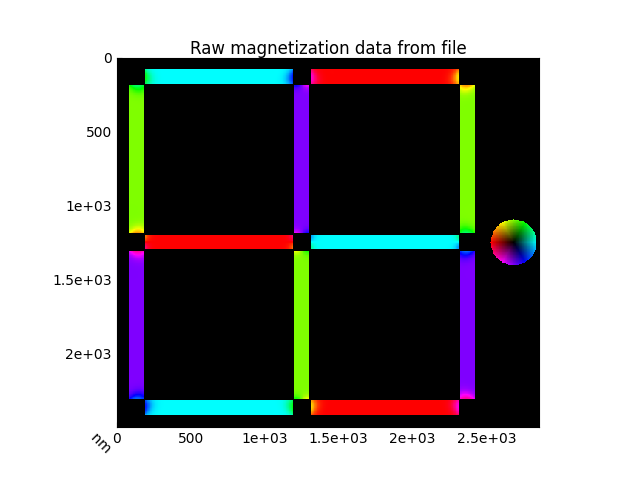

In [3]:
from colorwheel import color_im
mag_x, mag_y, mag_z, del_px, zscale = load_ovf(file, 'norm', B0, v=0)
# The input ovf might be many layers thick, so we sum along the z-direction to 
# make a 2D image to display. 
show_im(color_im(np.sum(mag_x, axis=0), np.sum(mag_y,axis=0), hsvwheel=True), 
        title="Raw magnetization data from file", cbar=False, scale=del_px)

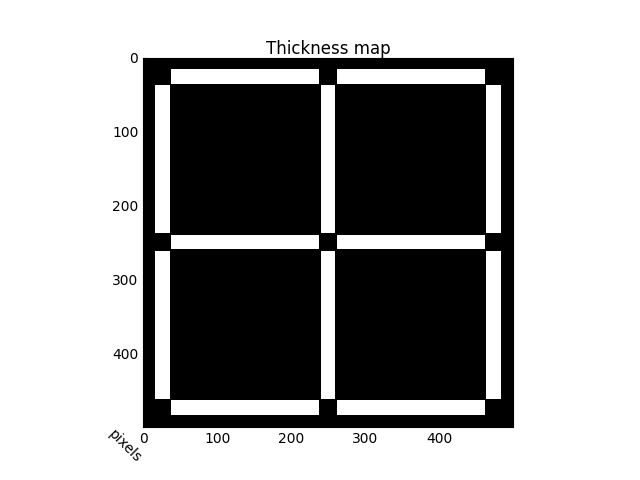

In [4]:
thk_map = make_thickness_map(mag_x, mag_y, mag_z)
show_im(thk_map.sum(axis=0), "Thickness map", cbar=False)

In [5]:
pscope = Microscope(E=200e3, Cs = 200.0e3, theta_c = 0.01e-3, def_spr = 80.0, verbose=True)
defval = 100_000 # nm
theta_x = 0 # degrees
theta_y = 0 # degrees
add_random = 0 # unitless scaling factor
flip=True # Bool


            Creating a new microscope object with the following properties:
            Quantities preceded by a star (*) can be changed using optional arguments at call.
            ------------------------------------------------------------------
            *Accelerating voltage               E: [V]    {self.E: 4.4g}
            *Spherical Aberration             Cs: [nm]    {self.Cs: 4.4g}
            *Chromatic Aberration             Cc: [nm]    {self.Cc: 4.4g}
            *Beam Coherence             theta_c: [rad]    {self.theta_c: 4.4g}
            *2-fold astigmatism               Ca: [nm]    {self.Ca: 4.4g}
            *2-fold astigmatism angle     phi_a: [rad]    {self.phi_a: 4.4g}
            *defocus spread              def_spr: [nm]    {self.def_spr: 4.4g}
            Electron wavelength           lambda: [nm]    {self.lam: 4.4g}
            Relativistic factor             gamma: [-]    {self.gamma: 4.4g}
            Interaction constant       sigma: [1/V/nm]    {self.sig

Text file found
Simulation size (z, y, x) : (1, 500, 500)
Image scale : 5 nm/pixel.
Calculating phase shift with Mansuripur algorithm. 
Total fov is (2.5e+03,2.5e+03) nm
Aligning for defocus value: 100000, with both flip/unflip tfs.
Reconstructing with normal Laplacian method
Calling TIE solver



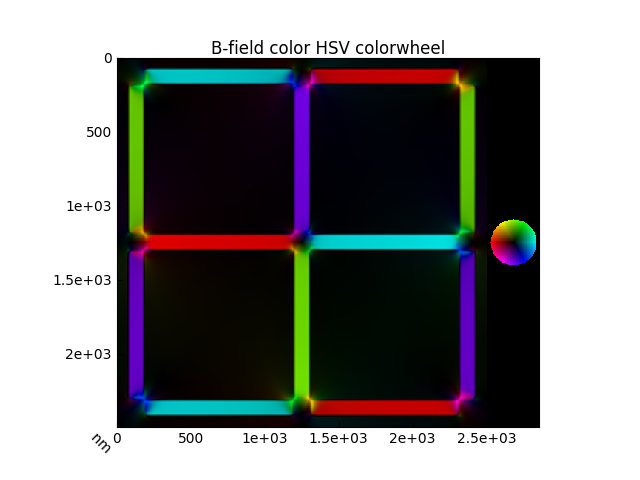

Phase reconstruction completed.


In [6]:
savename = 'Example_islands'
method = "mans" # use mansuripur algorithm if no sample tilt
save=0
v=1

results = reconstruct_ovf(file=file, save=save, savename=savename, v=v, 
                          flip=flip, pscope=pscope, defval=defval, theta_x=theta_x, 
                          theta_y=theta_y, add_random=add_random, thk_map=thk_map,
                          B0=B0, sample_V0=sample_V0, sample_xip0=sample_xip0, 
                          mem_thk=mem_thk, mem_xip0=mem_xip0, method=method)

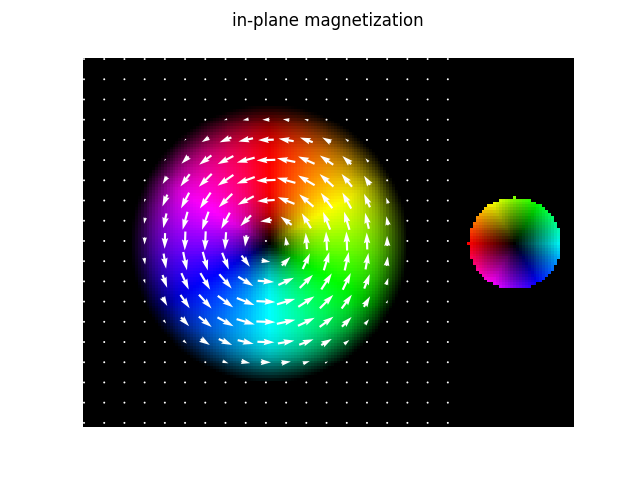

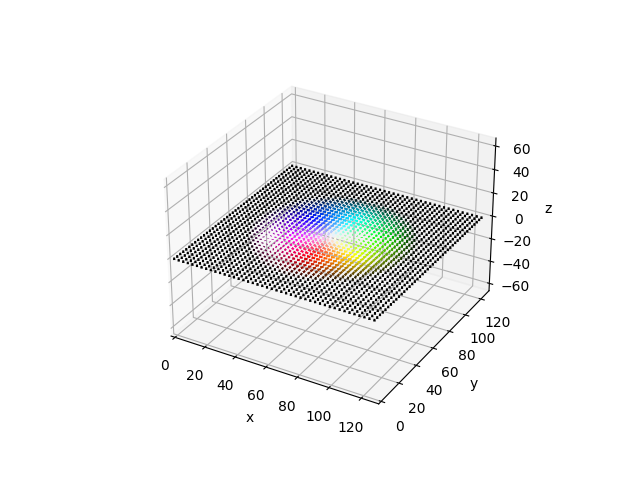

In [7]:
dim = 128
del_px = 500/dim # nm/pixel
zscale = 10 # nm/pixel in the z-direction
b0 = 1e4 # Gauss 
V0 = 10 # V
Bloch_x, Bloch_y, Bloch_z = Bloch(dim, chirality = 'cw', pad = True, ir=0)
show_2D(Bloch_x, Bloch_y, a=20, l=0.15, w=0.75, title='in-plane magnetization', color=True)
show_3D(Bloch_x, Bloch_y, Bloch_z, show_all = True, l=2, a = 50)

Beginning phase calculation for 16384 voxels.
Running in parallel with numba.
total time: 4.6277 sec, 0.00028245 sec/voxel.


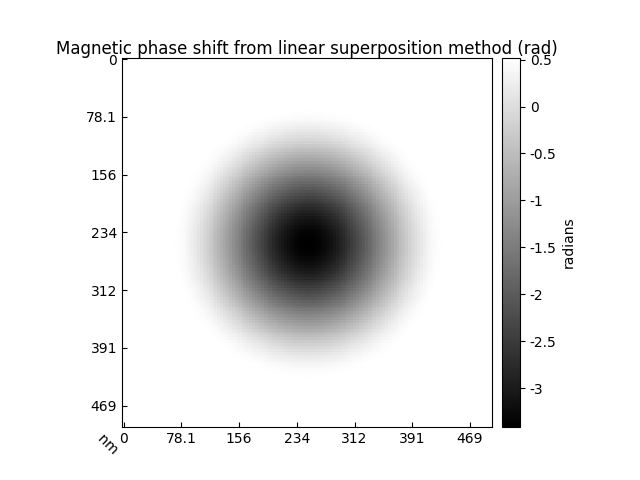

In [8]:
phi0 = 2.07e7 # Gauss*nm^2 
pre_B_L = 2*np.pi*b0*zscale*del_px/phi0
thickness_nm = zscale * 1 # 1 layer only, so thickness is just 10nm
pre_E = Microscope().sigma*V0*thickness_nm

ephi_L, mphi_L = linsupPhi(mx=Bloch_x.reshape(1,dim,dim),
                           my=Bloch_y.reshape(1,dim,dim),
                           mz=Bloch_z.reshape(1,dim,dim), 
                           pre_B=pre_B_L,
                           theta_x=0,
                           pre_E=pre_E)
show_im(mphi_L, "Magnetic phase shift from linear superposition method (rad)", scale=del_px, cbar_title="radians")
# show_im(ephi_L, "Electrostatic phase shift from linear superposition method (rad)")

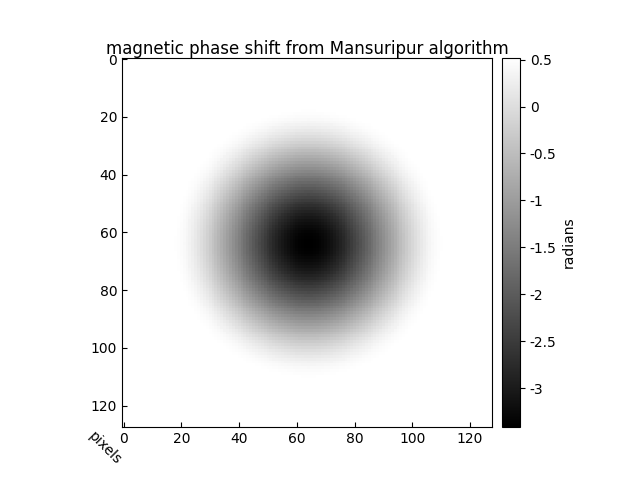

In [9]:
# Apply mansuripur algorithm with some standard materials parameters. 
ephi_m, mphi_m = std_mansPhi(Bloch_x, Bloch_y, Bloch_z, 
                             isl_thk=zscale*1, # thickness of the magnetic structure in nm, 1 layer thick here
                             zscale=zscale, 
                             del_px=del_px,
                             b0=b0, isl_V0=V0)
show_im(mphi_m, title="magnetic phase shift from Mansuripur algorithm", cbar_title="radians")
# show_im(ephi_m, title="electrostatic phase shift from Mansuripur algorithm")

Total fov is (500,500) nm


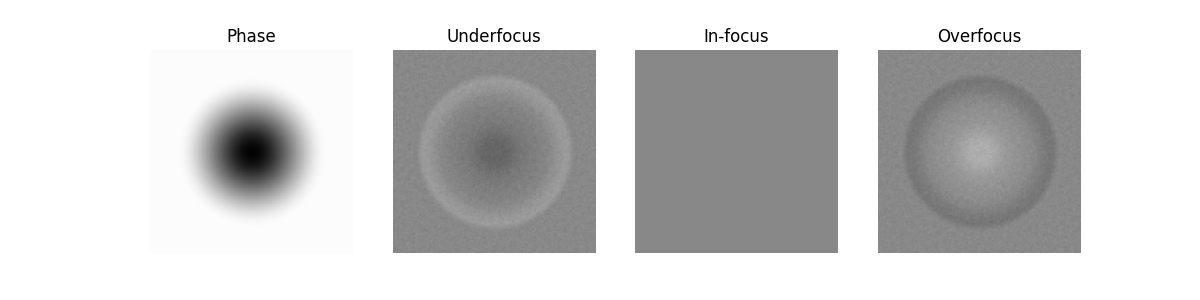

In [10]:
# using the linear superposition phase 
ALTEM = Microscope(E=200e3,Cs = 200.0e3, theta_c = 0.01e-3, def_spr = 80.0)
defval = 100_000 # nm 
amorphous_noise = 0.2 # unitless scaling parameter 
Tphi, im_un, im_in, im_ov = sim_images(mphi=mphi_m, ephi=ephi_m, 
                                       pscope=ALTEM,
                                       del_px=del_px, 
                                       def_val=defval,
                                       add_random=amorphous_noise)
show_sims(Tphi, im_un, im_in, im_ov)